In [3]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import lightgbm as lgb

import os
import gc
import time
import math
import random
from tqdm.auto import tqdm

from sklearn.metrics import fbeta_score
from catboost import CatBoostClassifier
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import Levenshtein
import difflib
import gc
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True,nb_workers=24)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
#import pylcs

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
#y = pd.read_parquet('data/target.parquet')


In [6]:
MODE = 'train'
candidate_df = pd.read_csv('data/train_top50_fold0_cv_with_groundtruth_final_72044.csv')[['topics_ids','content_ids','target','fold']]
if MODE == 'val':
    candidate_df = candidate_df[candidate_df.fold == 0]
    X_embeds = np.load(f'data/features_50_{MODE}.npy')
if MODE != 'val':
    candidate_df = candidate_df[candidate_df.fold != 0]
    X_embeds = np.load(f'data/features_50_{MODE}.npy')
candidate_df = candidate_df.fillna("")

In [7]:
candidate_df.columns = ['topic_id','content_id','target','fold']

In [8]:
candidate_df

,topic_id,content_id,target,fold
0,t_3d9ad9931021,c_8a2c8da77d0c,1,3
1,t_3d9ad9931021,c_3f51421a7c85,0,3
2,t_3d9ad9931021,c_db7818729577,0,3
3,t_3d9ad9931021,c_eb7d5e2e1744,0,3
4,t_3d9ad9931021,c_60dd2fc8a271,0,3
...,...,...,...,...
3119822,t_70da08637930,c_70b185780f10,0,2
3119823,t_70da08637930,c_40b1fea5ad01,0,2
3119824,t_70da08637930,c_a73aa42d1be9,0,2
3119825,t_70da08637930,c_dbce33468856,0,2


In [9]:
topics = pd.read_csv('data/topics.csv')
content = pd.read_csv('data/content.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
#topics = topics[topics.id.isin(sample_submission.topic_id.unique())]

In [10]:
used_columns = ['id','title','description']

In [11]:
content = content[used_columns].add_prefix('content_')
topics = topics[used_columns].add_prefix('topic_')

In [12]:
candidate_df = candidate_df.merge(content,how='left',on=['content_id'])
candidate_df = candidate_df.merge(topics,how='left',on=['topic_id'])
del topics,content;gc.collect()

0

In [13]:
def reduce_memory(df):
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df

def categorical_similarity(A, B):
    if not A or not B:
        return -1

    A = set(str(A).split(", "))
    B = set(str(B).split(", "))

    # Find intersection of two sets
    nominator = A.intersection(B)

    similarity_1 = len(nominator) / len(A)
    similarity_2 = len(nominator) / len(B)

    return max(similarity_1, similarity_2)

def string_operation(s1, s2, op="seq_matcher"):
    if s1 and s2:
        if op == "seq_matcher":
            return difflib.SequenceMatcher(None, s1, s2).ratio()
        elif op == "lev_distance":
            return Levenshtein.distance(s1, s2)
        elif op == "jaro_winkler":
            return Levenshtein.jaro_winkler(s1, s2)
        elif op == "lcs":
            return FastLCS(str(s1), str(s2))
        elif op == "wratio":
            return fuzz.WRatio(s1, s2)
        elif op == "partialratio":
            return fuzz.partial_ratio(s1, s2)
        elif op == "superfastlcs":
            return pylcs.lcs_sequence_length(s1, s2)
            
    else:
        return -1
def isna_features(df,columns):
    for col in columns:
        df[f'{col}_isna'] = df[col].isnull().astype(int)
    df = reduce_memory(df)
    return df

def fillna_cols(df,columns):
    df_copy = df.copy()
    for col in columns:
        if 'title' in col:
            df_copy[col].fillna('no title',inplace=True)
        if 'description' in col:
            df_copy[col].fillna('no description',inplace=True)
    return df_copy

def gc_clear():
    for i in range(5):
        gc.collect()

In [14]:
candidate_df = isna_features(candidate_df,['content_title','content_description','topic_title','topic_description'])
candidate_df = fillna_cols(candidate_df,['content_title','content_description','topic_title','topic_description'])

In [15]:
def add_distance_features(df,similarity_cols):

    #df[f"categories_venn"] = df[['categories' + "_x", 'categories' + "_y"]].apply(lambda x: categorical_similarity(x['categories' + "_x"], x['categories' + "_y"]),axis=1)
    for c in tqdm(similarity_cols):
        df['content_' + c] = df['content_' + c].astype(str)
        df['topic_' + c] = df['topic_' + c].astype(str)
        df[f"{c}_partialratio"] = df[['topic_' + c, 'content_' + c]].parallel_apply(lambda x: string_operation(x['topic_' + c], x['content_' + c],op="partialratio"),axis=1)
        #df[f"{c}_lcs"] = df[['topic_' + c, 'content_' + c]].parallel_apply(lambda x: string_operation(x['topic_' + c], x['content_' + c],op="lcs"),axis=1)
        df[f"{c}_wratio"] = df[['topic_' + c, 'content_' + c]].parallel_apply(lambda x: string_operation(x['topic_' + c], x['content_' + c],op="wratio"),axis=1)
        df[f"{c}_seqm"] = df[['topic_' + c, 'content_' + c]].parallel_apply(lambda x: string_operation(x['topic_' + c], x['content_' + c],op="seq_matcher"),axis=1)
        df[f"{c}_leven"] = df[['topic_' + c, 'content_' + c]].parallel_apply(lambda x: string_operation(x['topic_' + c], x['content_' + c],op="lev_distance"),axis=1)           
        df[f"{c}_jaro"] = df[['topic_' + c, 'content_' + c]].parallel_apply(lambda x: string_operation(x['topic_' + c], x['content_' + c],op="jaro_winkler"),axis=1)
        df[f"{c}_venn"] = df[['topic_' + c, 'content_' + c]].parallel_apply(lambda x: categorical_similarity(x['topic_' + c], x['content_' + c]),axis=1)
        
        df[f"{c}_len"] = df['content_' + c].astype(str).map(len)
        df[f"{c}_len2"] = df['topic_' + c].astype(str).map(len)
        df[f'{c}_len_diff'] = np.abs(df[f"{c}_len"] - df[f"{c}_len2"])
        df[f"{c}_nleven"] = df[f'{c}_leven'] / \
                                df[[f'{c}_len', f'{c}_len2']].max(axis=1)

        #df = df.drop(columns=f'{c}_len', axis=1)
        #df = df.drop(columns=f'{c}_len2', axis=1)
        df = reduce_memory(df)
        #df.drop(columns=[c + "_x", c + "_y"], axis=1, inplace=True)
        gc.collect()

    return df
similarity_cols = ['description','title']
candidate_df = add_distance_features(candidate_df,similarity_cols)

  0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
to_drop = ['content_title','content_description','topic_title','topic_description']
candidate_df = candidate_df.drop(to_drop,axis=1)

In [17]:
groups = candidate_df['topic_id'].values

In [18]:
idxs = candidate_df[['topic_id','content_id']]

In [19]:
X = candidate_df.drop(['target','fold','topic_id','content_id'],axis=1)
y = candidate_df['target']

In [20]:
X_embeds.shape,X.shape

((2504627, 1536), (2504627, 24))

In [21]:
group_kfold = GroupKFold(n_splits=5)

In [48]:
thresh = 0.15
PCA_COMP = 100
f1_errs = []
pca_models = []
lbg_models = []
for fold, (train_index, val_index) in enumerate(group_kfold.split(X, y, groups=groups)):
    print(f"Fold {fold}")
    X_train, X_val = X[X.index.isin(train_index)], X[X.index.isin(val_index)]
    y_train, y_val = y[y.index.isin(train_index)], y[y.index.isin(val_index)]
    X_embeds_train, X_embeds_val = X_embeds[train_index], X_embeds[val_index]
    print(X_embeds_train.shape, X_embeds_val.shape)
    print('training PCA..')
    pca = PCA(n_components=PCA_COMP,random_state=1)
    pca.fit(X_embeds_train)
    pca_models.append(pca)
    X_embeds_train,X_embeds_val = pca.transform(X_embeds_train),pca.transform(X_embeds_val)
    print(X_embeds_train.shape, X_embeds_val.shape)
    X_train = pd.concat([X_train.reset_index(drop=True),pd.DataFrame(X_embeds_train,columns=[f"embed_{i}" for i in range(1,PCA_COMP+1)])],axis=1).set_index(train_index)
    X_val = pd.concat([X_val.reset_index(drop=True),pd.DataFrame(X_embeds_val,columns=[f"embed_{i}" for i in range(1,PCA_COMP+1)])],axis=1).set_index(val_index)
    print("Final Shape",X_train.shape,X_val.shape)
    train_dataset = lgb.Dataset(data=X_train, label=y_train)
    val_dataset = lgb.Dataset(data=X_val, label=y_val)
    params = {'objective':'binary',
              'n_estimators':10_000,
              'learning_rate':0.1,
              'subsample':0.8,
              #'max_depth':8,
              #'num_leaves':60,
              'feature_fraction':0.7,
              'scale_pos_weight':2,
              'device_type':'cpu',
              'random_state':1,
              'verbosity':0
             }
    clf = lgb.train(
                    params,
                    train_set=train_dataset,
                    valid_sets=[train_dataset, val_dataset],
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=100),
                        lgb.log_evaluation(100)
                    ]
                )
    lbg_models.append(clf)
    train_pred = clf.predict(X_train)
    val_pred = clf.predict(X_val)
    print('Train F1: ',f1_score(y_train, (train_pred>thresh).astype(int)))
    print('Val F1', f1_score(y_val, (val_pred>thresh).astype(int)))
    
    #if fold == 0:
    #    break

Fold 0
(2003716, 1536) (500911, 1536)
training PCA..
(2003716, 100) (500911, 100)
Final Shape (2003716, 124) (500911, 124)


/home/ubuntu/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.261300 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.239639	valid_1's binary_logloss: 0.244676
[200]	training's binary_logloss: 0.225216	valid_1's binary_logloss: 0.233285
[300]	training's binary_logloss: 0.217194	valid_1's binary_logloss: 0.22817
[400]	training's binary_logloss: 0.210991	valid_1's binary_logloss: 0.22448
[500]	training's binary_logloss: 0.205656	valid_1's binary_logloss: 0.221443
[600]	training's binary_logloss: 0.200834	valid_1's binary_logloss: 0.218904
[700]	training's binary_logloss: 0.196641	valid_1's binary_logloss: 0.216792
[800]	training's binary_logloss: 0.19271	valid_1's binary_logloss: 0.214939
[900]	training's binary_logloss: 0.189064	valid_1's binary_logloss: 0.213264
[1000]	training's binary_logloss: 0.185754	valid_1's binary_logloss: 0.211791
[1100

/home/ubuntu/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250576 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.240161	valid_1's binary_logloss: 0.241972
[200]	training's binary_logloss: 0.226028	valid_1's binary_logloss: 0.231322
[300]	training's binary_logloss: 0.217784	valid_1's binary_logloss: 0.225845
[400]	training's binary_logloss: 0.211358	valid_1's binary_logloss: 0.221946
[500]	training's binary_logloss: 0.206161	valid_1's binary_logloss: 0.219081
[600]	training's binary_logloss: 0.201349	valid_1's binary_logloss: 0.216651
[700]	training's binary_logloss: 0.197163	valid_1's binary_logloss: 0.21467
[800]	training's binary_logloss: 0.193245	valid_1's binary_logloss: 0.212794
[900]	training's binary_logloss: 0.189487	valid_1's binary_logloss: 0.210873
[1000]	training's binary_logloss: 0.186116	valid_1's binary_logloss: 0.209166
[11

/home/ubuntu/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252724 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.239429	valid_1's binary_logloss: 0.245854
[200]	training's binary_logloss: 0.225044	valid_1's binary_logloss: 0.234603
[300]	training's binary_logloss: 0.217169	valid_1's binary_logloss: 0.229304
[400]	training's binary_logloss: 0.210823	valid_1's binary_logloss: 0.22546
[500]	training's binary_logloss: 0.205479	valid_1's binary_logloss: 0.222444
[600]	training's binary_logloss: 0.20079	valid_1's binary_logloss: 0.220022
[700]	training's binary_logloss: 0.196412	valid_1's binary_logloss: 0.217817
[800]	training's binary_logloss: 0.192534	valid_1's binary_logloss: 0.215913
[900]	training's binary_logloss: 0.188833	valid_1's binary_logloss: 0.214079
[1000]	training's binary_logloss: 0.18551	valid_1's binary_logloss: 0.212497
[1100

/home/ubuntu/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247960 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.239954	valid_1's binary_logloss: 0.243698
[200]	training's binary_logloss: 0.225715	valid_1's binary_logloss: 0.232227
[300]	training's binary_logloss: 0.217525	valid_1's binary_logloss: 0.226689
[400]	training's binary_logloss: 0.211404	valid_1's binary_logloss: 0.222988
[500]	training's binary_logloss: 0.206022	valid_1's binary_logloss: 0.219891
[600]	training's binary_logloss: 0.201399	valid_1's binary_logloss: 0.217355
[700]	training's binary_logloss: 0.197024	valid_1's binary_logloss: 0.214891
[800]	training's binary_logloss: 0.193309	valid_1's binary_logloss: 0.213066
[900]	training's binary_logloss: 0.189805	valid_1's binary_logloss: 0.211392
[1000]	training's binary_logloss: 0.186197	valid_1's binary_logloss: 0.209632
[1

/home/ubuntu/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241807 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.238723	valid_1's binary_logloss: 0.246031
[200]	training's binary_logloss: 0.224301	valid_1's binary_logloss: 0.234465
[300]	training's binary_logloss: 0.216372	valid_1's binary_logloss: 0.229147
[400]	training's binary_logloss: 0.210309	valid_1's binary_logloss: 0.225669
[500]	training's binary_logloss: 0.2052	valid_1's binary_logloss: 0.222844
[600]	training's binary_logloss: 0.200451	valid_1's binary_logloss: 0.220389
[700]	training's binary_logloss: 0.196107	valid_1's binary_logloss: 0.218185
[800]	training's binary_logloss: 0.192177	valid_1's binary_logloss: 0.216247
[900]	training's binary_logloss: 0.188534	valid_1's binary_logloss: 0.214517
[1000]	training's binary_logloss: 0.185278	valid_1's binary_logloss: 0.213018
[110

<AxesSubplot:>

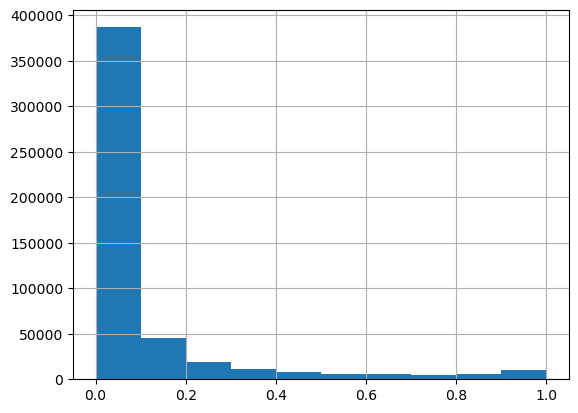

In [49]:
pd.Series(val_pred).hist()

In [50]:
feature_imp = pd.DataFrame({'Value':clf.feature_importance(),'Feature':X_train.columns}).sort_values('Value',ascending=False)
feature_imp

,Value,Feature
25,3085,embed_2
28,2901,embed_5
95,2804,embed_72
101,2757,embed_78
123,2716,embed_100
21,2674,title_len2
119,2666,embed_96
107,2654,embed_84
111,2646,embed_88
118,2633,embed_95


In [82]:
thresh = 0.4
f1_score(y_train, (train_pred>thresh).astype(int)),f1_score(y_val, (val_pred>thresh).astype(int))

(0.8934896496281904, 0.5844019240542233)

In [52]:
def pipeline(mode,pca_models=None,gbdt_models=None, embed_shape=100):
    candidate_df = pd.read_parquet('data/candidates_50_train_7840.parquet')[['topics_ids','content_ids','target','fold']]
    candidate_df = candidate_df[candidate_df.fold == 0]
    print("Candidate Shape:", candidate_df.shape)
    X_embeds = np.load('data/features_50_val.npy')
    candidate_df.columns = ['topic_id','content_id','target','fold']
    topics = pd.read_csv('data/topics.csv')
    content = pd.read_csv('data/content.csv')
    #sample_submission = pd.read_csv('data/sample_submission.csv')
    topics = topics[topics.id.isin(candidate_df.topic_id.unique())]
    used_columns = ['id','title','description']
    content = content[used_columns].add_prefix('content_')
    topics = topics[used_columns].add_prefix('topic_')
    candidate_df = candidate_df.merge(content,how='left',on=['content_id'])
    candidate_df = candidate_df.merge(topics,how='left',on=['topic_id'])
    del topics,content;gc.collect()
    
    candidate_df = isna_features(candidate_df,['content_title','content_description','topic_title','topic_description'])
    candidate_df = fillna_cols(candidate_df,['content_title','content_description','topic_title','topic_description'])
    similarity_cols = ['description','title']
    candidate_df = add_distance_features(candidate_df,similarity_cols)
    to_drop = ['content_title','content_description','topic_title','topic_description']
    candidate_df = candidate_df.drop(to_drop,axis=1)
    
    if mode == 'train':
        groups = candidate_df['topic_id'].values
        idxs = candidate_df[['topic_id','content_id']]
        y = candidate_df['target']
        group_kfold = GroupKFold(n_splits=5)
    X = candidate_df.drop(['target','fold','topic_id','content_id'],axis=1)
    
    if mode == 'val':
        y_preds = []
        for fold in range(0,len(pca_models)):
            X_embeds_small = pca_models[fold].transform(X_embeds)
            print(X_embeds_small.shape)
            X_test = pd.concat([X.reset_index(drop=True),pd.DataFrame(X_embeds_small,columns=[f"embed_{i}" for i in range(1,embed_shape+1)])],axis=1)
            y_preds.append(gbdt_models[fold].predict(X_test))
    if mode == 'val':
        return y_preds

In [53]:
y_predicted = pipeline(mode='val', pca_models=pca_models, gbdt_models=lbg_models, embed_shape=PCA_COMP)

Candidate Shape: (615200, 4)


  0%|                                                     | 0/2 [00:00<?, ?it/s]

 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.97s/it]

100%|█████████████████████████████████████████████| 2/2 [00:36<00:00, 18.21s/it]


(615200, 100)
(615200, 100)
(615200, 100)
(615200, 100)
(615200, 100)


In [54]:
y_predicted

[array([0.494793  , 0.04790724, 0.02105421, ..., 0.00580588, 0.02259164,
        0.23737781]),
 array([0.8488655 , 0.00613431, 0.00511739, ..., 0.00895668, 0.05325166,
        0.26633345]),
 array([0.29296283, 0.02277217, 0.02077438, ..., 0.00659104, 0.02186799,
        0.24976229]),
 array([0.67405427, 0.03341875, 0.01584646, ..., 0.00962327, 0.03666635,
        0.36873624]),
 array([0.57507363, 0.04763113, 0.01370416, ..., 0.02202528, 0.02583454,
        0.17136102])]

<AxesSubplot:>

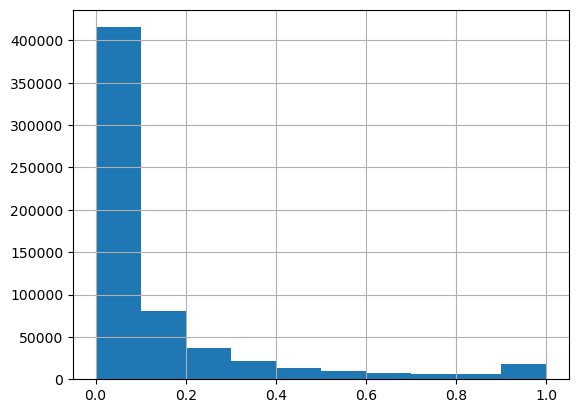

In [55]:
pd.Series(np.mean(y_predicted,axis=0)).hist()

### Kaggle Like Eval Hold-out

In [77]:
test = pd.read_csv('data/train_top50_fold0_cv_with_groundtruth_final_72044.csv')
test = test[test.fold == 0]
test['pred_prob'] = np.mean(y_predicted,axis=0)
test['pred_binary'] = (np.mean(y_predicted,axis=0)>0.1).astype(int)
test = test.sort_values('pred_prob',ascending=False).reset_index(drop=True)
gt = pd.read_csv('kfold_correlations.csv')
gt = gt[gt.fold == 0]
gt.drop('fold',axis=1,inplace=True)
gt.content_ids = gt.content_ids.str.split(' ')
preds = test[test.pred_binary==1].groupby(['topics_ids'])['content_ids'].agg(list).rename('content_ids_pred').reset_index()
no_pos = test[test.pred_binary==0].groupby(['topics_ids']).head(1)
no_pos = no_pos[~no_pos.topics_ids.isin(preds.topics_ids)].groupby(['topics_ids'])['content_ids'].agg(list).rename('content_ids_pred').reset_index()
preds = pd.concat([preds,no_pos],axis=0)
preds.columns = ['topic_id','content_ids_pred']
gt = gt.merge(preds,how='left',on='topic_id')
gt['content_ids_pred'] = gt['content_ids_pred'].fillna("")
gt['correct_pred'] = gt[['content_ids_pred', 'content_ids']].apply(lambda x: len([d for d in x[0] if d in x[1]]), axis=1)
gt['precision'] = gt['correct_pred']/(gt['content_ids_pred'].str.len() + 1e-7)
gt['recall'] = gt['correct_pred']/(gt['content_ids'].str.len() + 1e-7)
for beta in [0.5, 1, 2]:
        gt['f'+str(beta)] = ((1 + beta**2) * gt['precision'] * gt['recall'])/((beta**2 * gt['precision']) + gt['recall'] + 1e-7) 

In [78]:
gt.f2.mean()

0.36290432163102154

In [75]:
from tqdm import tqdm
thresholds = []
scores = []
max_score = 0
#test = pd.read_csv('data/train_top50_fold0_cv_with_groundtruth_final_72044.csv')
#test = test[test.fold == 0]
for thres in tqdm(np.arange(0.01, 0.99, 0.01)):
    thresholds.append(thres)
    #test['pred_prob'] = y_predicted
    test = pd.read_csv('data/train_top50_fold0_cv_with_groundtruth_final_72044.csv')
    test = test[test.fold == 0]
    test['pred_binary'] = (np.mean(y_predicted,axis=0)>thres).astype(int)
    #test = test.sort_values('pred_prob',ascending=False).reset_index(drop=True)
    
    gt = pd.read_csv('kfold_correlations.csv')
    gt = gt[gt.fold == 0]
    gt.drop('fold',axis=1,inplace=True)
    gt.content_ids = gt.content_ids.str.split(' ')
    preds = test[test.pred_binary==1].groupby(['topics_ids'])['content_ids'].agg(list).rename('content_ids_pred').reset_index()
    #no_pos = test[test.pred_binary==0].groupby(['topics_ids']).head(1)
    #no_pos = no_pos[~no_pos.topics_ids.isin(preds.topics_ids)].groupby(['topics_ids'])['content_ids'].agg(list).rename('content_ids_pred').reset_index()
    #preds = pd.concat([preds,no_pos],axis=0)
    preds.columns = ['topic_id','content_ids_pred']
    gt = gt.merge(preds,how='left',on='topic_id')
    gt['content_ids_pred'] = gt['content_ids_pred'].fillna("")
    gt['correct_pred'] = gt[['content_ids_pred', 'content_ids']].apply(lambda x: len([d for d in x[0] if d in x[1]]), axis=1)
    gt['precision'] = gt['correct_pred']/(gt['content_ids_pred'].str.len() + 1e-7)
    gt['recall'] = gt['correct_pred']/(gt['content_ids'].str.len() + 1e-7)
    for beta in [0.5, 1, 2]:
            gt['f'+str(beta)] = ((1 + beta**2) * gt['precision'] * gt['recall'])/((beta**2 * gt['precision']) + gt['recall'] + 1e-7)
    score = gt.f2.mean()
    if score > max_score:
        max_score = score
        best_thres = thres
    scores.append(gt.f2.mean())

100%|███████████████████████████████████████████| 98/98 [04:23<00:00,  2.69s/it]


In [76]:
best_thres, max_score

(0.11, 0.36219917706614985)

In [46]:
max(scores)

0.5294696699038235

In [79]:
pd.DataFrame([thresholds,scores]).T

,0,1
0,0.01,0.243137
1,0.02,0.274636
2,0.03,0.299041
3,0.04,0.317746
4,0.05,0.331333
5,0.06,0.342138
6,0.07,0.349593
7,0.08,0.355212
8,0.09,0.358941
9,0.10,0.360733


In [80]:
gt['len'] = gt.content_ids_pred.apply(lambda x: len(x))#.sort_values()

In [81]:
gt.len.value_counts().sort_values()

43     53
44     55
42     59
46     61
41     64
40     64
34     71
38     75
45     77
47     77
37     79
35     79
48     80
39     81
36     82
33     91
32     97
30    113
49    119
31    119
28    120
27    134
29    140
26    146
25    159
24    162
23    188
22    188
21    228
20    240
19    247
18    268
17    339
16    352
15    358
14    375
13    399
50    413
12    414
2     453
11    496
4     500
10    505
9     512
8     523
3     547
6     549
1     573
7     576
5     604
Name: len, dtype: int64

In [50]:
pca_models

[PCA(n_components=100, random_state=1),
 PCA(n_components=100, random_state=1),
 PCA(n_components=100, random_state=1),
 PCA(n_components=100, random_state=1),
 PCA(n_components=100, random_state=1)]

In [54]:
from sklearn.decomposition import PCA
from joblib import dump, load
for fold in range(0, len(pca_models)):
    dump(pca_models[fold], f'pca_{fold}.joblib')
    lbg_models[fold].save_model(f'lgb_{fold}.json')
    #pk.dump(pca_models[fold], open(f"models/pca_{fold}.pkl","wb"))


# later reload the pickle file
#pca_reload = pk.load(open("pca.pkl",'rb'))
#result_new = pca_reload .transform(X)